# Restauración de información en mapas bidimensionales obtenidos en experimentos por dispersión de rayos X.

# Parte II

Autor: Gustavo Quintero

28 de Mayo 2021

## 1. Resumen

En este trabajo se aplican dos métodos de restauración de imágenes en mapas de transmisión, absorción y dispersión obtenidos a través SAXS, para mejorar la calidad de los mapas obtenidos y extraer información estructural de la muestra en estudio con una mejor precisión y un mayor peso estadístico. El trabajo se estructura en dos experiencias, cada una asociada a un cuaderno (notebook) específico:

- En la primera experiencia se obtuvo el mapa de transmisión y absorción de una semilla de chía seca.

- En la segunda experiencia se hidrató una semilla de chía diferente, y se realizó la medición para obtener los mapas de transmisión, absorción y los patrones de dispersión. La medición para el mapa de transmisión y absorción se efectuó de manera similar a la experiencia anterior, mientras que, para la medición de los patrones de dispersión se colocó el beam stopper (eliminando la transmisión de la muestra) del instrumento.


## 2. Librerias

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fabio
import re
import os
import cv2
import matplotlib.colors

from celluloid import Camera
from matplotlib.ticker import LogFormatter
from matplotlib import ticker, cm
from tifffile import imread, imsave
from scipy.signal import fftconvolve
from pandas import Series, DataFrame
from numpy import nan as NA
from mpl_toolkits.mplot3d import Axes3D
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.restoration import richardson_lucy, unsupervised_wiener

## 3. Funciones

In [2]:
def scalematrix(m, scale):
  # Crear matriz con ceros del tamaño apropiado
  r = np.zeros(((m.shape[0]-1)*scale+1, (m.shape[1]-1)*scale+1))

  # Rellenar filas multiplo de scale (interpolando entre valores de los elementos de la fila)
  for fil in range(m.shape[0]):
    for col in range(m.shape[1]-1):
      r[fil*scale, col*scale:(col+1)*scale+1] = np.linspace(m[fil,col], m[fil,col+1], scale+1)

  # Rellenar resto de ceros, interpolando entre elementos de las columnas
  for fil in range(m.shape[0]-1):
    for col in range(r.shape[1]):
      r[fil*scale:(fil+1)*scale + 1, col] = np.linspace(r[fil*scale,col], r[(fil+1)*scale, col], scale+1)
  return r

## 4. Datos

Se hidrató una semilla de chía con la finalidad de producir un hinchamiento en su superficie y propiciar la formación de una capa de hidrogel alrededor de ella. Luego, se midio el mapa de transmisión y dispersión para esta muestra. 

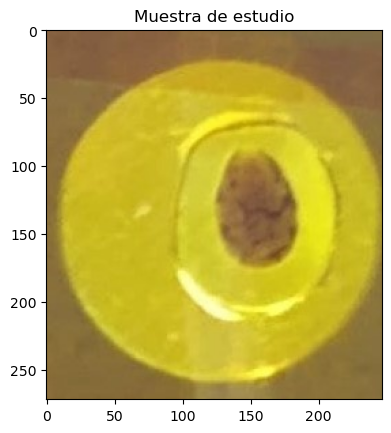

In [3]:
Chia_h = imread('Chia_hidratada.tiff')
plt.imshow(Chia_h)
plt.title('Muestra de estudio')
plt.show()

Se abre el archivo que se obtuvo de la medición asociada al mapa de transmisión y se extraen los datos con los que se van a trabajar.

In [4]:
with open('20210428_saxs_a1.log','r') as file:
    data = file.read()
pattern = '(?<=\#L)[^#L]*(?=#S)'
data = re.findall(pattern,data)

Se ordenan los datos en un diccionario para poder manipularlos de una mejor manera haciendo uso de un DataFrame

In [5]:
table={}
for i in range(0,len(data)):
    s = data[i]
    s = [text.strip() for text in s.splitlines()]
    s = [text.split() for text in s]
    s[0]= list(pd.unique(s[0]))
    s[0].pop(5)
    s.pop(len(s)-1)
    data1 = {}
    for j in range(0,len(s[0])):
        data1[s[0][j]]=[]
        for k in range(1,len(s)):
            data1[s[0][j]].append(float(s[k][j]))
    table[str(i+1)]= data1
data = pd.DataFrame(table)
data

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
X,"[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....",...,"[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2....","[-3.0, -2.8333285, -2.6666569, -2.4999854, -2...."
Epoch,"[40.319, 42.327, 44.357, 46.35, 48.427, 50.426...","[109.078, 111.17, 113.323, 115.382, 117.432, 1...","[177.982, 179.955, 181.998, 184.098, 186.138, ...","[246.546, 248.663, 250.75, 252.718, 254.77, 25...","[316.247, 318.247, 320.53, 322.557, 324.711, 3...","[386.183, 388.158, 390.135, 392.15, 394.178, 3...","[454.443, 456.494, 458.479, 460.586, 462.722, ...","[523.464, 525.57, 527.589, 529.575, 531.599, 5...","[592.047, 594.083, 596.154, 598.227, 600.235, ...","[660.518, 662.487, 664.502, 666.518, 668.555, ...",...,"[1416.766, 1418.834, 1420.819, 1422.962, 1425....","[1485.121, 1487.155, 1489.198, 1491.253, 1493....","[1553.974, 1555.99, 1558.106, 1560.198, 1562.3...","[1623.13, 1625.153, 1627.258, 1629.299, 1631.4...","[1692.042, 1694.127, 1696.098, 1698.151, 1700....","[1761.366, 1763.382, 1765.494, 1767.531, 1769....","[1830.346, 1832.314, 1834.258, 1836.234, 1838....","[1898.818, 1900.896, 1902.994, 1905.049, 1907....","[1967.886, 1969.905, 1971.939, 1973.923, 1976....","[2037.103, 2039.091, 2041.091, 2043.219, 2045...."
Seconds,"[0.504, 0.503, 0.504, 0.504, 0.503, 0.504, 0.5...","[0.504, 0.504, 0.505, 0.504, 0.505, 0.504, 0.5...","[0.504, 0.505, 0.503, 0.504, 0.504, 0.505, 0.5...","[0.505, 0.504, 0.504, 0.504, 0.504, 0.506, 0.5...","[0.504, 0.505, 0.504, 0.504, 0.504, 0.505, 0.5...","[0.504, 0.504, 0.505, 0.504, 0.504, 0.507, 0.5...","[0.504, 0.505, 0.504, 0.504, 0.507, 0.505, 0.5...","[0.504, 0.503, 0.503, 0.504, 0.505, 0.504, 0.5...","[0.505, 0.504, 0.509, 0.505, 0.509, 0.507, 0.5...","[0.504, 0.507, 0.504, 0.506, 0.505, 0.504, 0.5...",...,"[0.504, 0.5, 0.506, 0.504, 0.505, 0.506, 0.506...","[0.505, 0.504, 0.504, 0.507, 0.505, 0.503, 0.5...","[0.504, 0.504, 0.504, 0.504, 0.507, 0.504, 0.5...","[0.504, 0.506, 0.503, 0.504, 0.504, 0.503, 0.5...","[0.504, 0.503, 0.503, 0.505, 0.504, 0.504, 0.5...","[0.504, 0.504, 0.504, 0.503, 0.504, 0.503, 0.5...","[0.504, 0.504, 0.503, 0.504, 0.504, 0.506, 0.5...","[0.504, 0.503, 0.504, 0.504, 0.507, 0.505, 0.5...","[0.504, 0.504, 0.506, 0.504, 0.506, 0.505, 0.5...","[0.503, 0.503, 0.504, 0.503, 0.505, 0.504, 0.5..."
Detector,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0

Una vez ordenados, se procede a extraer los valores de intensidades transmitidas (fila 'Roi0'), para poder visualizar el mapa (imagen) de transmisión.

In [6]:
color = 'jet'

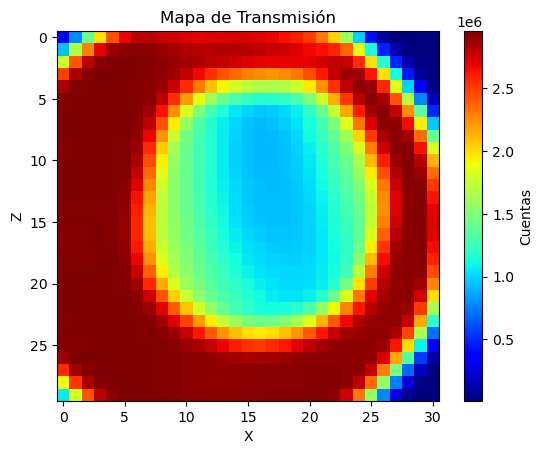

In [7]:
a = data.iloc[-1]
I = [a[i] for i in range(0,len(a))]
I = np.array(I)
plt.imshow(I, cmap = color)
plt.title('Mapa de Transmisión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

Luego, se divide cada pixel del mapa de transmisión con el valor de tiempo asociado (fila 'Seconds' del DataFrame) para disminuir el error de cuentas en el detector que presentan los datos. 

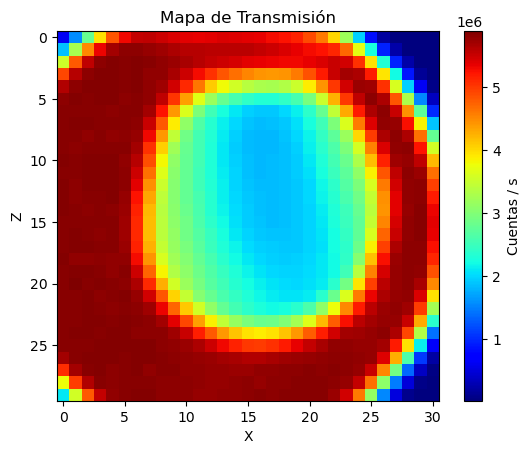

In [8]:
b = data.iloc[2]
T = [b[i] for i in range(0,len(b))]
T = np.array(T)
G = I/T
plt.imshow(G, cmap = color)
plt.title('Mapa de Transmisión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas / s")
plt.show()

Para obtener el mapa de dispersión a partir de los datos, se realiza un enmascaramiento de las zonas muertras presentes en los patrones de dispersión medidos; ya que la señal de SAXS proviene de
la integral de todos los fotones registrados en el detector (descontando las zonas enmascaradas). 

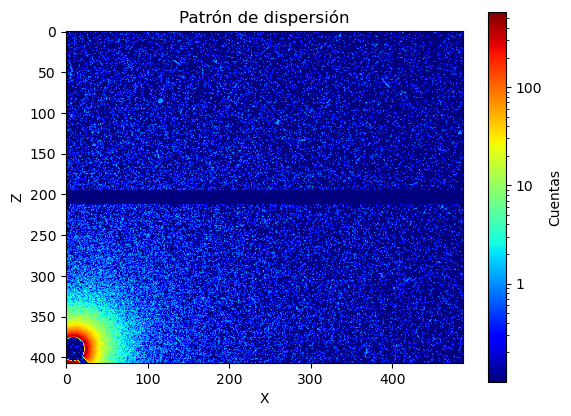

In [9]:
img = fabio.open("Cristian_20210428_0_00530.edf")
pd = img.data
A = np.where(pd > 0, pd, 0.1)
#A[A==0]=0.1
#A = np.log(A)
#plt.imshow(pd)
#plt.clim(0, 10)
plt.imshow(A, norm=matplotlib.colors.LogNorm(), cmap = color)
formatter = LogFormatter(10, labelOnlyBase=False) 
cb = plt.colorbar(label='Cuentas', format=formatter)
plt.title('Patrón de dispersión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.show()

Las zonas muertas son dos, la primera un rectángulo, que corresponde al espaciado entre los
detectores, y la segunda corresponde al beam stopper del instrumento. El criterio para identificar la primera zona, son los valores que la conforman, porque en esta zona se ubican los únicos valores negativos dentro del patrón de dispersión, mientras que, para identificar la segunda zona el criterio fue un poco más complejo.

El primer paso para identificar la segunda zona, es seleccionar un corte de un patrón de
dispersión con buen contraste con el beam stopper, para luego aplicar segmentación por regiones, siguiendo el criterio del valor umbral.

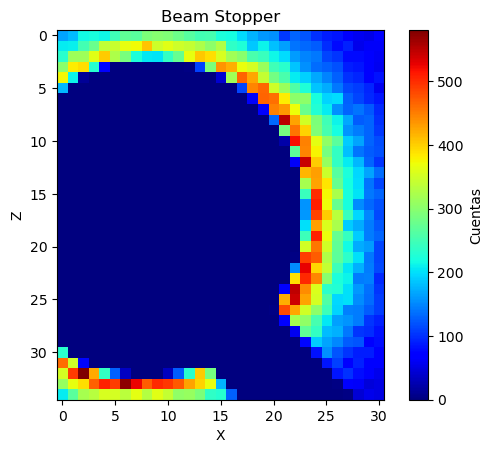

In [10]:
A = np.where(pd < 0, NA, pd)
B = A[372:407,0:31]
plt.imshow(B, cmap = color)
plt.title('Beam Stopper')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

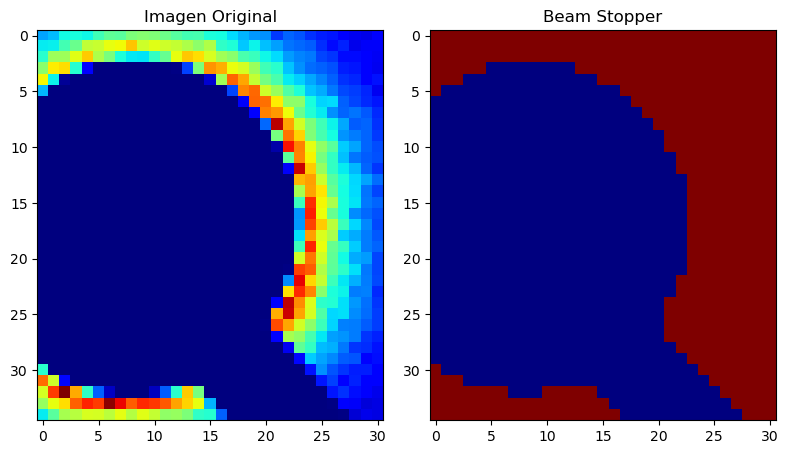

In [11]:
C = np.where(B >10,1,0)
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(B, cmap = color)
ax[0].set_title("Imagen Original", fontsize=12)

ax[1].imshow(C, cmap = color)
ax[1].set_title("Beam Stopper", fontsize=12)

fig.tight_layout()
plt.show()

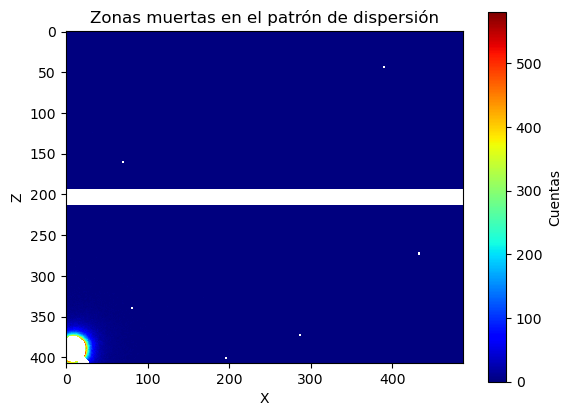

In [12]:
i,j = C.shape
m = []
for k in range(i):
    for l in range(j):
        if C[k,l] == 0:
            m.append(k + 372)
            m.append(l)
            
for i in range(0,len(m),2):
    j = i+1
    A[m[i],m[j]] = NA

    
plt.imshow(A, cmap = color) 
plt.colorbar(label='Cuentas')
plt.title('Zonas muertas en el patrón de dispersión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.show()

Una vez identificadas y enmascaradas las zonas muertas, se hace la suma de todos los pixeles en cada patrón de dispersión (900 en total), obteniendo así el valor de la intensidad dispersada por cada píxel del mapa de transmisión. Luego, con estos valores se construye el mapa de dispersión.

In [13]:
ruta= os.getcwd()
ruta = ruta + '\\Cristian_20210428'
a = []
for file in os.listdir(ruta):
    if file.endswith('edf'):
        #print(file)
        img = fabio.open(ruta+'\\'+file)
        pdd = img.data
        pdd = np.where(pdd < 0, 0, pdd)
        for i in range(0,len(m),2):
            j = i+1
            pdd[m[i],m[j]] = 0
        a.append(np.sum(pdd))
        #print(np.sum(pdd))

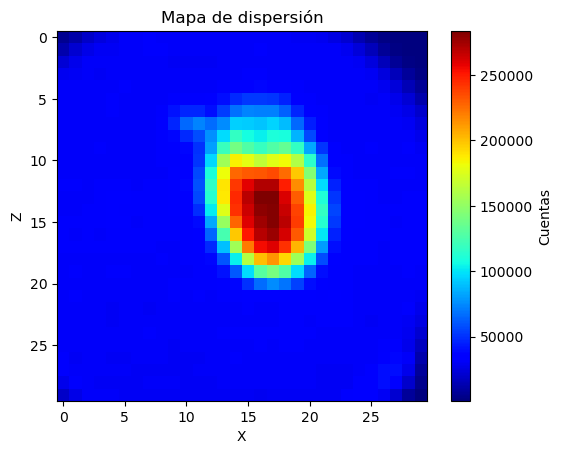

In [14]:
M = np.zeros((30,30))
i,j = M.shape
q = 0
for o in range(i):
    for p in range(j):
        M[o,p] = a[q]
        q += 1
plt.imshow(M, cmap = color)
plt.title('Mapa de dispersión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

Cada píxel en el mapa de intensidad del haz incidente sobre la muestra tiene dimensiones de $0.167𝑚𝑚$, mientras que cada píxel en el mapa de transmisión y dispersión de la muestra mide $0.172𝑚𝑚$, por lo que, para llevar acabo la restauración, es necesario redimensionar el mapa del haz utilizando un factor de escala.

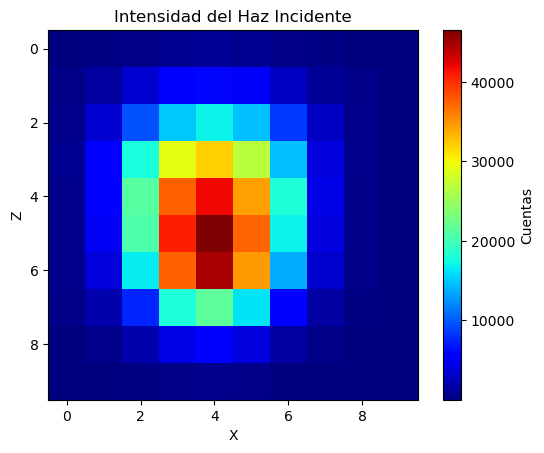

In [15]:
h2 = np.load('h2.npy')
plt.imshow(h2, cmap = color)
plt.title('Intensidad del Haz Incidente')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas")
plt.show()

In [16]:
i,j = np.where(h2 == np.amax(h2))
h12=h2[i[0]-1:i[0]+2,j[0]-1:j[0]+2]

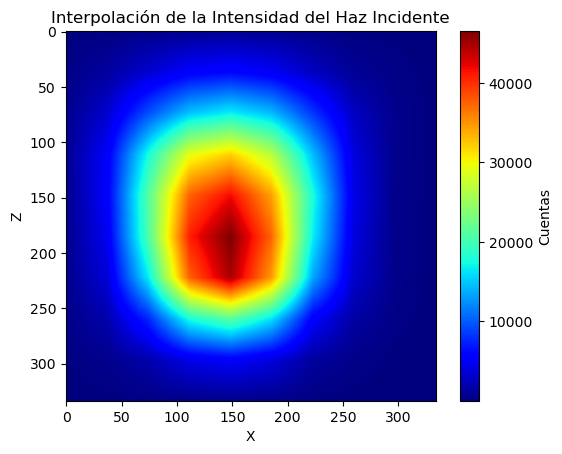

In [17]:
h8 = scalematrix(h2, scale=37)
plt.imshow(h8, cmap = color)
plt.title('Interpolación de la Intensidad del Haz Incidente')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas")
plt.show()

In [18]:
i,j = np.where(h8 == np.amax(h8))
h9=h8[i[0]-53:i[0]+55,j[0]-53:j[0]+55]
i,j = np.where(h9 == np.amax(h9))
h9[i,j] = 0
i,j

(array([53], dtype=int64), array([53], dtype=int64))

In [19]:
#plt.imshow(h9)
#plt.xlabel('X') 
#plt.ylabel('Z')
#plt.colorbar(label="Cuentas")
#plt.show()

In [20]:
h10=np.zeros((108,3))
a = 0
for i in range(108):
    m = 0
    k = 0
    for j in range(108):
        a += h9[i,j]
        if k == 35:
            h10[i,m]+=(a/36)
            a = 0
            k = 0
            m += 1
        k+=1
#h10
h11=np.zeros((3,3))
a = 0
for j in range(3):
    m = 0
    k = 0
    for i in range(108):
        a += h10[i,j]
        if k == 35:
            h11[j,m]+=(a/36)
            a = 0
            k = 0
            m += 1
        k+=1
i,j = np.where(h11 == np.amax(h11))

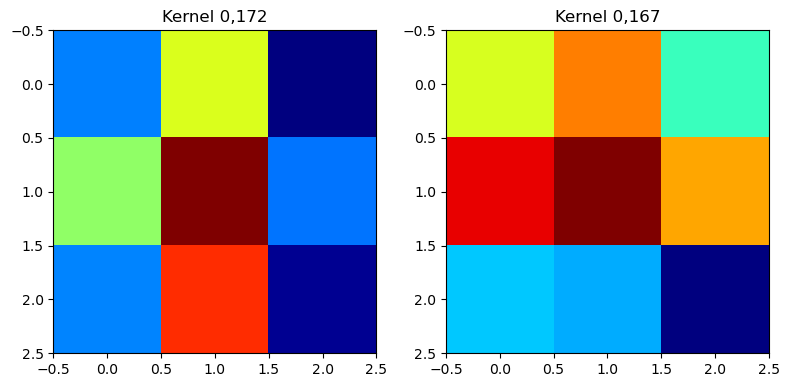

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(h12, cmap = color)
ax[0].set_title("Kernel 0,172", fontsize=12)

ax[1].imshow(h11, cmap = color)
ax[1].set_title("Kernel 0,167", fontsize=12)

fig.tight_layout()
plt.show()

## 5. Procesamiento de Datos

A partir del mapa de transmisión, se obtiene el mapa relacionado con el coeficiente de absorción de la muestra (aplicando el mismo método y transformación que en la primera experiencia)

**Método 1**

In [22]:
mean1 = np.mean(G[5:25,0:5])
mean1

5838164.642359491

**Método 2**

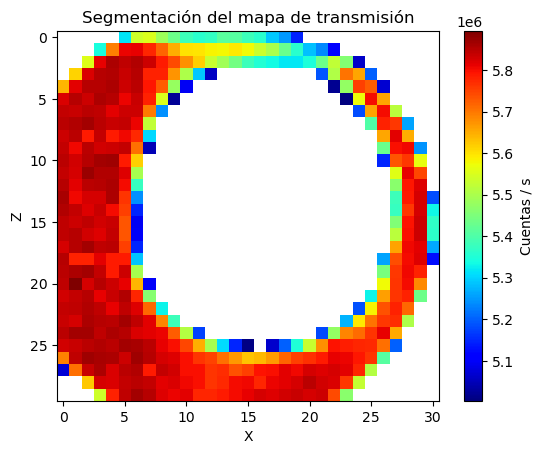

In [23]:
F = np.where(G>5e6,G,NA)
non_nan_indices = np.where(~np.isnan(F[:,0:30]))
#coordinates_non_nan = list(zip(non_nan_indices[0], non_nan_indices[1]))
plt.imshow(F, cmap = color)
plt.title('Segmentación del mapa de transmisión')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label="Cuentas / s")
plt.show()

In [24]:
nan_indices = np.isnan(F)
mean2 = np.mean(F[~nan_indices])
mean2

5679425.420639159

In [25]:
print('Método 1: {0:.2f}, Método 2: {1:.2f}'.format(mean1,mean2))

Método 1: 5838164.64, Método 2: 5679425.42


Ahora, se aplica la transformación para obtener el mapa de absorción haciendo uso del valor obtenido en el segundo método (segmentación).

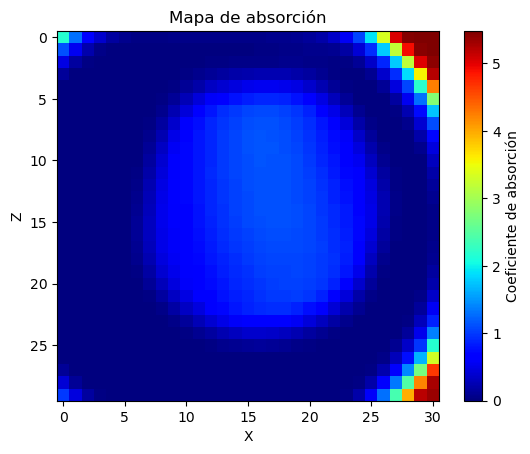

In [26]:
H = np.zeros(G.shape)
H = H+mean2
R = np.log(H/G)
R = np.where(R > 0, R, 0)
plt.imshow(R, cmap = color)
plt.title('Mapa de absorción')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Coeficiente de absorción')
plt.show()

Para mejorar la calidad del mapa de dispersión,se toma un valor promedio a partir de un conjunto de valores, en la zona correspondiente al portamuestra (zona segmentada en el método 2). Posteriormente se resta este valor (dispersión de fondo) a cada píxel del mapa obteniendo el mapa de dispersión sin dispersión de fondo.

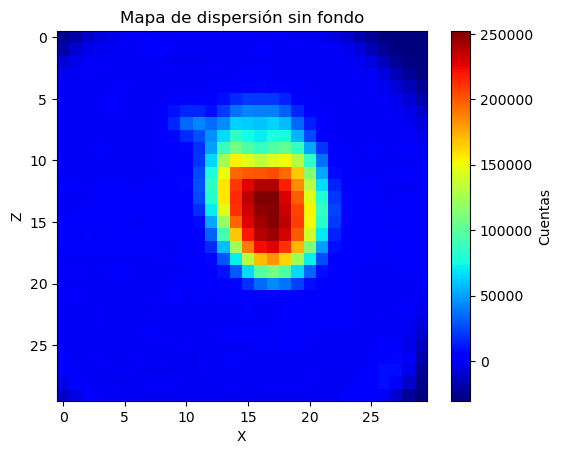

In [27]:
values_non_nan = M[non_nan_indices]
mean3 = np.mean(values_non_nan)
#mean3 = np.mean(M[5:25,0:5])
N = M-mean3
plt.imshow(N, cmap = color)
plt.title('Mapa de dispersión sin fondo')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

Luego, se hace la división elemento a elemento del mapa de dispersión con
el mapa de transmisión (eliminando previamente la última columna del mapa de transmisión, para que ambos mapas sean de la misma dimensión), logrando quitar las inhomogeneidades
asociadas al espesor de la muestra, obteniendo el mapa de dispersión normalizado

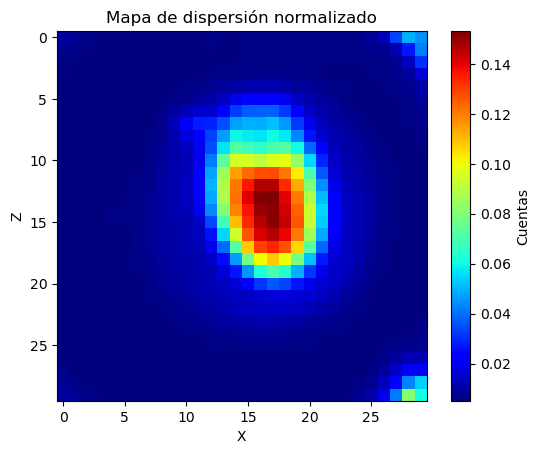

In [28]:
G = G[0:30,0:30]
O = M/G
plt.imshow(O, cmap = color)
plt.title('Mapa de dispersión normalizado')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

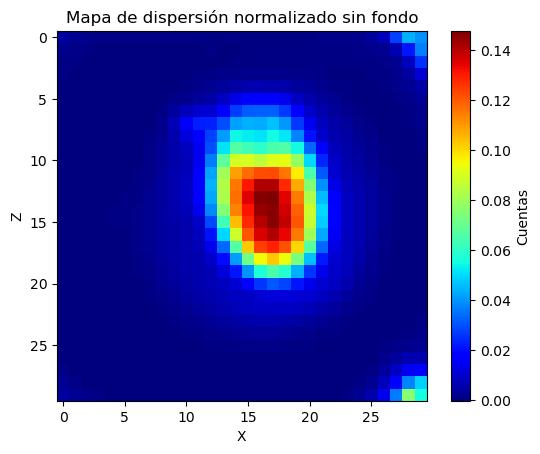

In [29]:
#values_non_nan =O[non_nan_indices]
#mean4 = np.mean(values_non_nan)
mean4 = np.mean(O[5:25,0:5])
P = O-mean4
plt.imshow(P, cmap = color)
plt.title('Mapa de dispersión normalizado sin fondo')
plt.xlabel('X') 
plt.ylabel('Z')
plt.colorbar(label='Cuentas')
plt.show()

## 5. Restauración (deconvolución)

Basados en los resultados de la restauración de la primera experiencia, se aplica el
método de R-L a el mapa de dispersión normalizada.

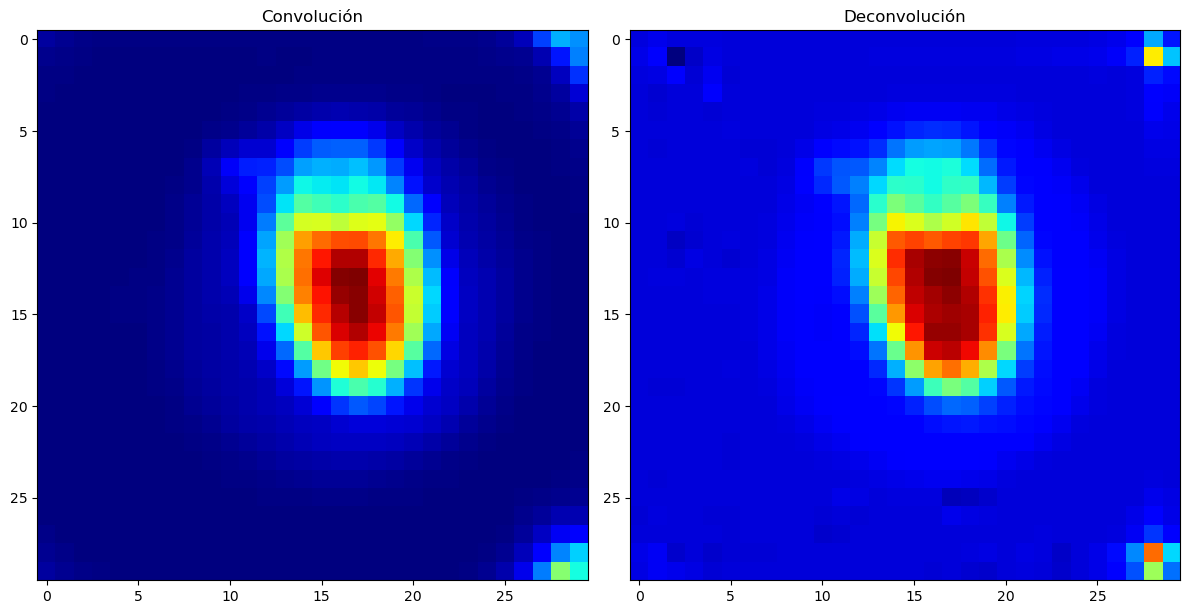

In [30]:
d1 = richardson_lucy(P, h11, num_iter=5, clip = False)

fig, axes = plt.subplots(1, 2, figsize=(12, 8))
ax = axes.ravel()

ax[0].imshow(P, cmap = color)
ax[0].set_title("Convolución")
ax[1].imshow(d1, cmap = color)
ax[1].set_title('Deconvolución')

fig.tight_layout()
plt.show()

En la restauración obtenida para el mapa de dispersión normalizada, se
puede notar un cambio en el rango de los valores que toman los pixeles con respecto al
mapa degradado, desde el punto de vista del nivel desenfoque, hay un cambio ligeramente
perceptible entre los bordes de la semilla, la capa del hidrogel y el fondo. Además, se puede
apreciar la aparición de pixeles con valores negativos en la zona correspondiente al fondo
de la muestra, posiblemente asociados a la magnificación del ruido dado por el método de
restauración de R-L.